## install dependencies

In [5]:
from scipy.io import loadmat
import mat73
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from tqdm import notebook
from scipy import stats
from scipy.signal import hilbert
from scipy.signal import butter, sosfiltfilt
from scipy import signal
from scipy.fft import fftshift
from kneed import KneeLocator
import pickle
import joblib


## load lfp (mat 7.3) file

In [6]:
filepath = '../processed_data/lfp.mat'

In [7]:
ey_lfp = mat73.loadmat(filepath)

In [8]:
fs = int(ey_lfp["lfp"]["samplerate"][0])
print(f'sampling frequency is {fs} Hz')

sampling frequency is 1250 Hz


In [9]:
full_lfp = np.vstack([ey_lfp['lfp']['data'][ch] for ch in range(len(ey_lfp['lfp']['data']))]).T
print(f'full LFP lasted for {full_lfp.shape[0]/(fs*60*60)} hours across {full_lfp.shape[1]} channels')

full LFP lasted for 4.540507555555555 hours across 39 channels


In [10]:
full_lfp.shape

(20432284, 39)

## define bandpower func

In [11]:
def bandpower(data, fs, band, method, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * fs
        else:
            nperseg = (2 / low) * fs

        freqs, psd = welch(data, fs, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, fs, adaptive=True,
                                          normalization='full', 
                                          verbose=0)
    else:
        print('Method not implemented.')

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
# define frequency ranges for band powers
freq_bands = [[3, 8], [10, 30], [30, 50], [50, 80]]
bands = ['theta', 'beta', 'lower_gamma', 'higher_gamma']
# initialize list
band_pow = []

# define window in seconds for frequency analysis
window_dur = 1
# define time total in hours for analysis
duration_total = 1

win_size = int(window_dur*fs) # sampling at 1250 Hz, 1s is 1250 samples
nun_overlaps = 10
win_num = int(duration_total*60*60/window_dur*nun_overlaps)

# for each band
for i, freq_band in enumerate(notebook.tqdm(freq_bands)):
    instant_band_pow_all = []
    # for each channel
    for ch in notebook.tqdm(range(full_lfp.shape[1])):
        instant_band_pow_single = []
        # for each analysis window
        for win in notebook.tqdm(range(win_num)): 
            # window will be minimum nyquist 2/low_cut
            bp = bandpower(full_lfp[int(win*win_size*1/nun_overlaps):int(win*win_size*1/nun_overlaps)+win_size, ch],
                                                 fs, 
                                                 freq_band, 
                                                 'welch'
                                                )
            # a list of instantaneous single band power single channel
            # instant_band_pow_single.append(np.mean(psd[idx_band])) 
            instant_band_pow_single.append(bp) 
        # a list of 39 channels, single band power
        instant_band_pow_all.append(np.hstack((instant_band_pow_single))) # instant_band_pow_all.append(np.array((instant_band_pow_single))) 
    band_pow.append(instant_band_pow_all)

In [ ]:
features = np.vstack(([np.vstack(band_pow[b]) for b in range(len(band_pow))]))
features.T.shape
# it'll print samples x (channels x num bands)

(36000, 156)

In [ ]:
zscore_feats = stats.zscore(features, axis=1)
zscore_feats.T.shape

(36000, 156)

In [ ]:
pickle.dump(zscore_feats, open('../processed_data/welch_band_pow.np', 'wb'))

In [12]:
zscore_feats = pickle.load(open('../processed_data/welch_band_pow.np', 'rb'))

## define maximum hmm states

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score(hmm_model, lpf_features, spikes, limit_count=100, verbose=False):
    Z2 = hmm_model.predict(lpf_features)
    X = spikes.copy()
    y = Z2[::int(lpf_features.shape[0]/spikes.shape[0])]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if verbose:
        print(X.shape, y.shape, [len(np.where(y == s)[0]) for s in np.unique(Z2)])
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []
    for s in np.unique(Z2):
        idx_s = np.where(y==s)[0]
        try:
            sampled_idx_s = np.random.choice(len(idx_s), limit_count, replace=False)
        except:
            sampled_idx_s = np.random.choice(len(idx_s), len(idx_s), replace=False)
        y_subsampled.append(y[idx_s[sampled_idx_s]])
        X_subsampled.append(X[idx_s[sampled_idx_s], :])
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average=None)

In [3]:
filename = '../processed_data/m1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'

with open(filename, 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate two hour m1 recording to one hour l5 recording into (36000, 46), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_l5_neurons_1h = spike_times_all_neurons[:36000, :46]

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_l5_neurons_1h_zscored = stats.zscore(spike_times_l5_neurons_1h) # Default axis is 0

spikes = spike_times_l5_neurons_1h_zscored
print(f'Spike times are binned into shape for hmm: {spikes.shape}')

Spike times are binned into shape for hmm: (36000, 46)


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/caravaggio/opt/anaconda3/envs/nsp/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

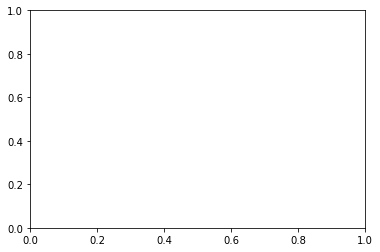

In [ ]:
f1_score_arr = []
for K in notebook.tqdm(range(1, 31)):
    hmm_curr = pickle.load(open(f'../hmm_models/hmm_welch/hmm_lpf_{K}_states.hmm', 'rb'))
    f1_score_arr.append(rf_f1_score(hmm_curr, zscore_feats.T, spikes, limit_count=1250, verbose=False))
plt.plot(range(1, 31), f1_score_arr)

  0%|          | 0/30 [00:00<?, ?it/s]

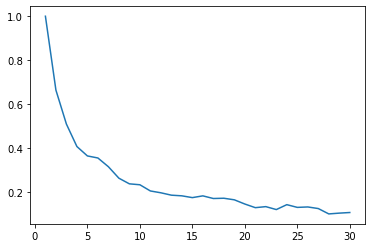

In [ ]:
f1_score_arr = []
for K in notebook.tqdm(range(1, 31)):
    hmm_curr = pickle.load(open(f'../hmm_models/hmm_welch/hmm_lpf_{K}_states.hmm', 'rb'))
    f1_score_arr.append(rf_f1_score(hmm_curr, zscore_feats.T, spikes, limit_count=1250, verbose=False))
plt.plot(range(1, 31), f1_score_arr)

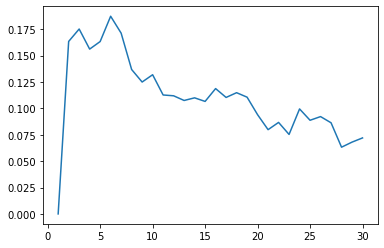

In [ ]:
plt.plot(range(1, 31), f1_score_arr - np.array([1/K for K in range(1, 31)]))

In [ ]:
K = np.argmax(f1_score_arr - np.array([1/K for K in range(1, 31)])) + 1

In [4]:
names_mod = ['insignificant', 'insignificant', 'insignificant', 'insignificant', 'rear',
         'insignificant', 'insignificant', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'insignificant', 'insignificant', 
         'paw groom', 'locomotion', 'insignificant', 'contra-orient']

In [159]:
names_mod[26]

'locomotion'

In [5]:
indices = [i for i, s in enumerate(names_mod) if not s.__eq__('insignificant')]

In [123]:
indices

[4, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28]

## Classify behaviors within hmm states

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score_sep_behav(data, targets, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []

    sig_idx = [i for i, s in enumerate(names_mod) if not s.__eq__('insignificant')]
    for s in np.unique(sig_idx):
        idx_s = np.where(y==s)[0]
        if len(idx_s) >= 20:
            try:
                sampled_idx_s = np.random.choice(len(idx_s), limit_count, replace=False)
            except:
                sampled_idx_s = np.random.choice(len(idx_s), len(idx_s), replace=False)
            y_subsampled.append(y[idx_s[sampled_idx_s]])
            X_subsampled.append(X[idx_s[sampled_idx_s], :])
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=2023)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(f'y_test from rf_sep:{np.unique(y_test, return_counts=True)}')
    return np.unique(y_train, return_counts=True), f1_score(y_test, predict, average=None)

In [7]:
import os
import sys
sys.path.append('../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

data_dir = r'../processed_data'
file_name = r'ag25290_day2_iter13'
# Load behaviors
behavior_loader = bsoid_loader(data_dir, file_name)
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_1h = smoothed_predictions[behavior_start:(behavior_start+3600*60):int(60/10)]

mouse stayed in nest for 0.28108749470484795% of time
smooth window: 12
File #0 (a 6 body parts by 984391 frames) has 30 classes


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score_smooth_behav(data, targets, smoothed_predictions_1h, random_state, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []
    sig_idx = [i for i, s in enumerate(names_mod) if not s.__eq__('insignificant')]
    for s in np.unique(sig_idx):
        idx_s = np.where(y==s)[0]
        idx_s_all = np.where(smoothed_predictions_1h==s)[0]
        if len(idx_s) >= 20:
            if len(idx_s) > 100:
                sampled_idx_s = np.random.choice(len(idx_s_all), 100, replace=False)
            else:
                sampled_idx_s = np.random.choice(len(idx_s_all), len(idx_s), replace=False)
            y_subsampled.append(smoothed_predictions_1h[idx_s_all[sampled_idx_s]])
            X_subsampled.append(X[idx_s_all[sampled_idx_s], :])
    
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=2023)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(f'y_test from rf_smooth:{np.unique(y_test, return_counts=True)}')
    
    return np.unique(y_train, return_counts=True), f1_score(y_test, predict, average=None)

In [105]:
K = 6
hmm_best = pickle.load(open(f'../hmm_models/hmm_welch/hmm_lpf_{K}_states.hmm', 'rb'))
hmm_states = hmm_best.predict(zscore_feats.T)[::int(zscore_feats.T.shape[0]/spikes.shape[0])]
uiq_y_train, f1_score_behav = rf_f1_score_sep_behav(spikes, smoothed_predictions_1h, limit_count=100, verbose=False)
f1_score_sep_behav_arr = []
uiq_y_train_arr = []
f1_score_smooth_behav_arr = []
uiq_y_smooth_train_arr = []
for hmm_state in notebook.tqdm(np.unique(hmm_states)):
    idx_ = np.where(hmm_states == hmm_state)[0]
    spikes_state = spikes[idx_, :]
    smoothed_predictions_1h_state = smoothed_predictions_1h[idx_]
    uniq_smoothed_predictions_1h_states, uniq_smoothed_predictions_1h_state_cnts = \
        np.unique(smoothed_predictions_1h_state, return_counts=True)
    for i, uniq_smoothed_predictions_1h_state in enumerate(uniq_smoothed_predictions_1h_states):
        uniq_smoothed_predictions_1h_state_cnt = uniq_smoothed_predictions_1h_state_cnts[i]
    uiq_y_sep_train, f1_score_sep_behav = rf_f1_score_sep_behav(spikes_state, smoothed_predictions_1h_state, limit_count=100, verbose=False)
    uiq_y_train_arr.append(uiq_y_sep_train)
    f1_score_sep_behav_arr.append(f1_score_sep_behav)

    uiq_y_smooth_train, f1_score_smooth_behav = rf_f1_score_smooth_behav(spikes, smoothed_predictions_1h_state, smoothed_predictions_1h, limit_count=100, verbose=False)
    uiq_y_smooth_train_arr.append(uiq_y_smooth_train)
    f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    

y_test from rf_sep:(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([20, 20, 18, 16, 21, 25, 23, 20, 19, 22, 20, 17, 23, 18, 18, 18]))


  0%|          | 0/6 [00:00<?, ?it/s]

y_test from rf_sep:(array([ 7,  8,  9, 10, 15, 17, 18, 20, 21, 25, 26], dtype=int32), array([19, 20, 15, 21, 24, 12, 10,  3, 13, 20, 19]))
y_test from rf_smooth:(array([ 7,  8,  9, 10, 15, 17, 18, 20, 21, 25, 26], dtype=int32), array([19, 20, 15, 21, 24, 12, 10,  3, 13, 20, 19]))
y_test from rf_sep:(array([ 7,  8,  9, 10, 14, 15, 17, 18, 20, 21, 25, 26, 28], dtype=int32), array([25, 19, 16, 11, 17, 18, 24,  7, 20, 22, 23, 22,  4]))
y_test from rf_smooth:(array([ 7,  8,  9, 10, 14, 15, 17, 18, 20, 21, 25, 26, 28], dtype=int32), array([25, 19, 16, 11, 17, 18, 24,  7, 20, 22, 23, 22,  4]))
y_test from rf_sep:(array([ 7,  8,  9, 10], dtype=int32), array([11, 16,  7,  8]))
y_test from rf_smooth:(array([ 7,  8,  9, 10], dtype=int32), array([11, 16,  7,  8]))
y_test from rf_sep:(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([10, 15, 23, 24, 19, 23, 26,  7, 18, 28, 20, 16, 10, 25, 10, 19]))
y_test from rf_smooth:(array([ 4,  7,  8,  9, 10, 14

In [56]:
uiq_y_train

(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
       dtype=int32),
 array([69, 81, 79, 72, 81, 80, 77, 76, 84, 82, 81, 83, 79, 83, 86, 77]))

In [57]:
f1_score_behav

array([0.41025641, 0.13333333, 0.18604651, 0.5106383 , 0.28571429,
       0.56521739, 0.23529412, 0.35897436, 0.17142857, 0.40909091,
       0.45      , 0.29268293, 0.51282051, 0.22222222, 0.42105263,
       0.42307692])

In [58]:
np.array([names_mod[i] for i in indices])

array(['rear', 'investigate type 1', 'investigate type 2', 'contra-itch',
       'investigate type 3', 'contra-body groom', 'face groom type 1',
       'dive/scrunch', 'head groom', 'ipsi-orient', 'face groom type 2',
       'ipsi-body groom', 'ipsi-itch type 1', 'paw groom', 'locomotion',
       'contra-orient'], dtype='<U18')

In [59]:
uiq_y_train_arr[0]


(array([ 7,  8,  9, 10, 15, 17, 18, 20, 21, 25, 26, 28], dtype=int32),
 array([75, 87, 52, 71, 85, 51, 46, 14, 67, 79, 78, 11]))

In [60]:
f1_score_sep_behav_arr[0]

array([0.74509804, 0.4       , 0.4375    , 0.57777778, 0.48484848,
       0.42857143, 0.44444444, 0.        , 0.66666667, 0.32      ,
       0.38095238, 0.28571429])

In [61]:
uiq_y_smooth_train_arr[0]

(array([ 7,  8,  9, 10, 15, 17, 18, 20, 21, 25, 26, 28], dtype=int32),
 array([75, 87, 52, 71, 85, 51, 46, 14, 67, 79, 78, 11]))

In [62]:
f1_score_smooth_behav_arr[0]

array([0.16216216, 0.31111111, 0.33333333, 0.31578947, 0.19354839,
       0.26666667, 0.26666667, 0.        , 0.4516129 , 0.4375    ,
       0.33898305, 0.        ])

In [63]:
f1_score_sep_behav_arr[0] - f1_score_smooth_behav_arr[0]

array([ 0.58293588,  0.08888889,  0.10416667,  0.2619883 ,  0.2913001 ,
        0.16190476,  0.17777778,  0.        ,  0.21505376, -0.1175    ,
        0.04196933,  0.28571429])

In [68]:
f1_score_sep_behav_arr[5], f1_score_smooth_behav_arr[5]

(array([0.        , 0.32432432, 0.15789474, 0.56521739, 0.06666667,
        0.33333333, 0.27777778, 0.30769231, 0.33333333, 0.20689655,
        0.26086957, 0.43902439, 0.        , 0.34782609, 0.17777778,
        0.25      ]),
 array([0.15789474, 0.27027027, 0.53061224, 0.14035088, 0.60606061,
        0.16216216, 0.13333333, 0.21428571, 0.36842105, 0.10526316,
        0.58536585, 0.        , 0.22222222, 0.23255814, 0.4       ]))

<BarContainer object of 6 artists>

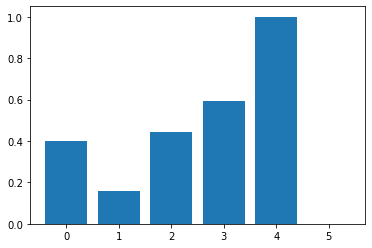

In [94]:
plt.bar(np.arange(len(f1_score_sep_behav_arr[2])), f1_score_sep_behav_arr[2] - f1_score_smooth_behav_arr[2])

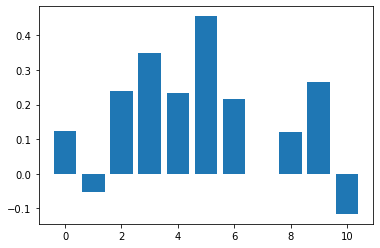

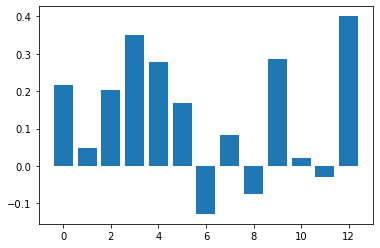

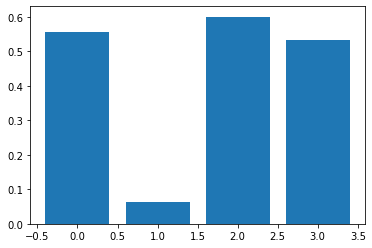

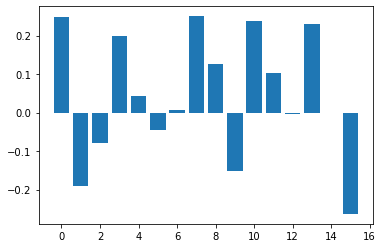

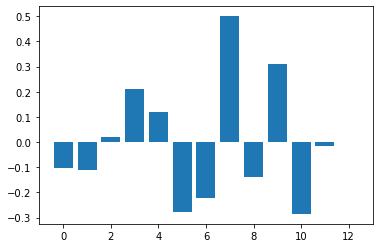

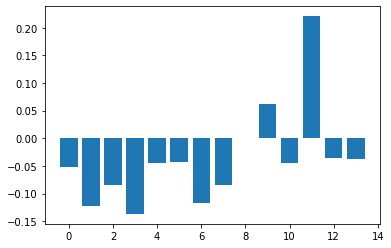

In [106]:
for i in range(6):
    plt.figure(i)
    plt.bar(np.arange(len(f1_score_sep_behav_arr[i])), f1_score_sep_behav_arr[i] - f1_score_smooth_behav_arr[i])

In [16]:
uiq_y_train_arr[1]

(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
       dtype=int32),
 array([17, 79, 81, 79, 52, 81, 78,  7, 79, 38, 81, 74, 16, 78, 88, 16]))

In [17]:
f1_score_sep_behav_arr[1]

array([0.66666667, 0.41025641, 0.30769231, 0.625     , 0.4       ,
       0.82051282, 0.35      , 0.        , 0.23076923, 0.        ,
       0.41025641, 0.73913043, 0.        , 0.1875    , 0.4516129 ,
       0.33333333])

In [18]:
uiq_y_train_arr[2]

(array([ 7,  8,  9, 10, 15, 22, 25, 26], dtype=int32),
 array([30, 85, 18, 39,  6,  4,  7,  7]))

In [24]:
f1_score_sep_behav_arr[2]

array([0.5       , 0.6       , 0.8       , 0.71428571, 0.4       ,
       0.66666667, 0.        , 0.        ])

In [19]:
f1_score_sep_behav_arr[3]

array([0.2       , 0.13333333, 0.31818182, 0.63636364, 0.27272727,
       0.4516129 , 0.16666667, 0.18181818, 0.10810811, 0.3255814 ,
       0.31746032, 0.3902439 , 0.55555556, 0.25      , 0.27777778,
       0.35      ])

In [152]:
uiq_y_train_arr[3]

(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
       dtype=int32),
 array([44, 81, 80, 77, 78, 83, 76, 83, 84, 77, 81, 75, 73, 83, 82, 85]))

In [20]:
f1_score_sep_behav_arr[4]

array([0.05555556, 0.        , 0.57142857, 0.39130435, 0.88888889,
       0.35      , 0.36363636, 0.46153846, 0.20689655, 0.        ,
       0.44      , 0.        , 0.32653061, 0.        ])

In [21]:
uiq_y_train_arr[4]

(array([ 7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 25, 26, 28],
       dtype=int32),
 array([78, 86, 49, 76, 26, 82, 31, 37, 62, 13, 76, 31, 81, 17]))

In [22]:
f1_score_sep_behav_arr[5]

array([0.        , 0.32432432, 0.15789474, 0.56521739, 0.06666667,
       0.33333333, 0.27777778, 0.30769231, 0.33333333, 0.20689655,
       0.26086957, 0.43902439, 0.        , 0.34782609, 0.17777778,
       0.25      ])

In [23]:
uiq_y_train_arr[5]

(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
       dtype=int32),
 array([16, 76, 84, 76, 78, 85, 77, 34, 65, 87, 46, 78,  7, 77, 82, 79]))

In [67]:
idx_ = np.where(hmm_states == 0)[0]
smoothed_predictions_1h_state = smoothed_predictions_1h[idx_]
behavs, cnts = np.unique(smoothed_predictions_1h_state, return_counts=True)
sig_cnts_list = []
for behav in behavs:
    if not names_mod[behav].__eq__('insignificant'):
        sig_cnts_list.append((names_mod[behav], cnts[behavs==behav]))
sig_cnts_list

[('contra-orient', array([21])),
 ('rear', array([4])),
 ('investigate type 1', array([105])),
 ('investigate type 2', array([849])),
 ('contra-itch', array([66])),
 ('investigate type 3', array([99])),
 ('contra-body groom', array([1])),
 ('face groom type 1', array([94])),
 ('dive/scrunch', array([12])),
 ('head groom', array([70])),
 ('ipsi-orient', array([76])),
 ('face groom type 2', array([16])),
 ('ipsi-body groom', array([80])),
 ('ipsi-itch type 1', array([9])),
 ('paw groom', array([93])),
 ('locomotion', array([513])),
 ('contra-orient', array([51]))]

In [63]:
'a'.__eq__('b')

False

In [46]:
idx_ = np.where(hmm_states == 5)[0]
smoothed_predictions_1h_state = smoothed_predictions_1h[idx_]
behav, cnts = np.unique(smoothed_predictions_1h_state, return_counts=True)
cnts

array([ 137,    8,    4,   17,   30,   15,   85,  793, 3397,  303,  301,
          2,    4,    5,   90,  176,  100,   58,  675,    9,   45,  155,
         68,  167,   42,  111, 4239,   64,  443])

In [47]:
idx_ = np.where(hmm_states == 2)[0]
smoothed_predictions_1h_state = smoothed_predictions_1h[idx_]
behav, cnts = np.unique(smoothed_predictions_1h_state, return_counts=True)
cnts

array([  6,  49,   5,   7,   9,  39, 458,  14,  48,   3,  10,   1,   3,
         6,   9,  10])

In [38]:
np.mean(f1_score_sep_behav)

0.28035379118716647

## visualize 1:1 mapping

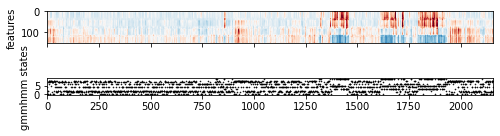

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(8, 2), gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
im = ax[0].imshow(zscore_feats[:, ::25], vmin=-3, vmax=3, cmap='RdBu_r')

ax[1].scatter(np.arange(len(Z2[::25])), Z2[::25], s=0.3, color='k')
ax[0].set_ylabel('features')
ax[1].set_ylabel('gmmhmm states')

# ax[1].set_xticks(np.arange(0, len(Z2), 180))
# ax[1].set_xticklabels(np.arange(0, 3, 0.5))
# ax[1].set_xlabel('Time (hrs)')
plt.show()
# fig.savefig('./lfp_hmm.png', dpi=300)


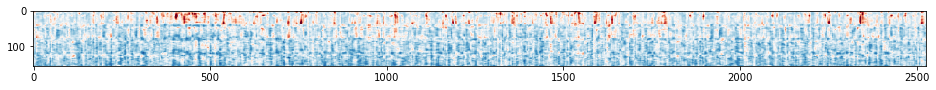

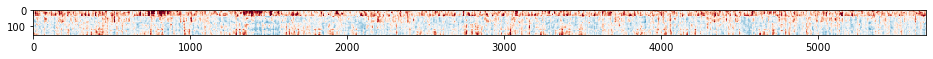

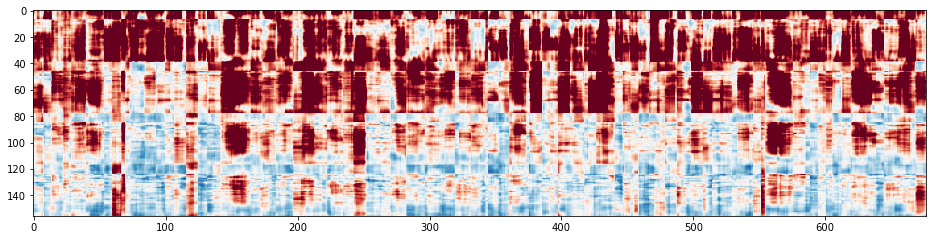

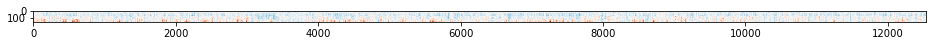

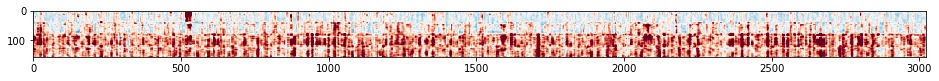

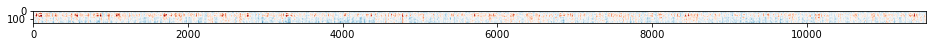

In [43]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 10), gridspec_kw={'height_ratios': [10, 1]}, sharex=True)
Z2 = hmm_best.predict(zscore_feats.T)[::int(zscore_feats.T.shape[0]/spikes.shape[0])]
rows = len(np.unique(Z2))
cols = 1
# fig, ax = plt.subplots(rows, cols, figsize=(20, 16), sharex=True, sharey=True)
# for hmm_state in np.arange(len(np.unique(Z2))):
for hmm_state in np.unique(Z2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(Z2==hmm_state)[0]
#     ax.plot(features[0, idx_])
    ax.imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')
#     ax[hmm_state].imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')


In [42]:
f1_score_sep_behav

[0.35052136875856515,
 0.27218404777665844,
 0.3294090524859756,
 0.23702240576150493,
 0.283139576835587,
 0.20984629550470746]

### 